In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D

In [2]:
input_dir = 'C:/Users/Trix/Documents/Feko/ALBATROS/LWA/'
output_dir = 'Z:/Documents/ALBATROS-Instrument-Paper/Figures/'

beam_pattern_fname = 'LWA.ffe'
S11_fname = 'lwa_s11.dat'
mismatch_fname = 'lwa_mismatch.dat'

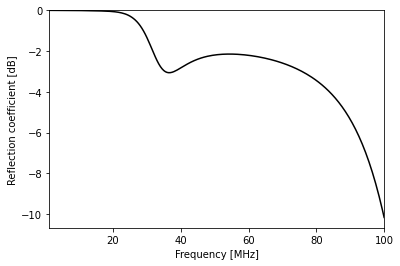

In [9]:
S11_data = np.loadtxt(input_dir+S11_fname, skiprows=2) # [Frequency (MHz), No ground screen, Regular ground screen, Large ground screen]
freq = np.linspace(1.2, 100, 53) # ignore frequency data for non-interpolated data
tol = 1e-8
idx = [i for i in range(len(S11_data[:,0])) if (np.abs(S11_data[i,0]/1e6 - freq) < tol).any()]
S11 = S11_data[idx,2]
np.save('S11.npy', S11)

# Interpolate
f = scipy.interpolate.interp1d(freq, S11, kind='cubic')
xx = np.linspace(1.2, 100, 200)

# fig = plt.figure(figsize=(10,6))
# plt.plot(freq, S11, '.')
plt.plot(xx, f(xx), 'k')
plt.xlim(1.2,100)
plt.ylim(top=0)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Reflection coefficient [dB]')
plt.savefig('s11.jpg')
plt.show()

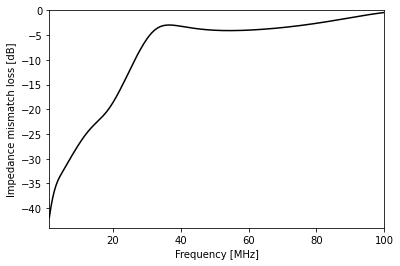

In [10]:
m_data = np.loadtxt(input_dir+mismatch_fname, skiprows=2) # [Frequency (MHz), No ground screen, Regular ground screen, Large ground screen]
tol = 1e-8
idx = [i for i in range(len(m_data[:,0])) if (np.abs(m_data[i,0]/1e6 - freq) < tol).any()]
mismatch = m_data[idx,2]
np.save('mismatch.npy', mismatch)

# Interpolate
f1 = scipy.interpolate.interp1d(freq, mismatch, kind='cubic')

# plt.plot(freq, mismatch, '.')
plt.plot(xx, f1(xx), 'k')
plt.xlim(1.2,100)
plt.ylim(top=0)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Impedance mismatch loss [dB]')
plt.savefig('mismatch.jpg')
plt.show()

In [6]:
freqs = np.linspace(1.2, 100, 53)
np.save('freqs.npy', freqs)

ntheta = 19
nphi = 73
nfreq = len(freqs)

line_number = 0
skiplines = 5 # only at top of file
headerlines = 10 # skip this number of lines for every frequency

beam = np.ones((nphi, ntheta, nfreq))
phimat = np.ones((nphi, ntheta))
thetamat = np.ones((nphi, ntheta))

# CODE FOR GETTING BEAM DATA FROM .FFE FILE
with open(input_dir+beam_pattern_fname, 'r') as file:
    n = 1
    for i, line in enumerate(file):
        if i >= skiplines + n*headerlines + (n-1)*nphi*ntheta and i < skiplines + n*headerlines + n*ntheta*nphi:
            j = i - skiplines - n*headerlines - (n-1)*ntheta*nphi
            u = j // ntheta
            v = j - u * ntheta
#             print(n, i, j, u, v)
            L = [float(x) for x in line.split()]
            beam[u,v,n-1] = L[-1]
            if n == 1:   
                thetamat[u,v] = L[0]
                phimat[u,v] = L[1]
            if j == ntheta*nphi - 1:
                n += 1

In [7]:
np.save('phimat.npy', phimat)
np.save('thmat.npy', thetamat)
np.save('beam.npy', beam)

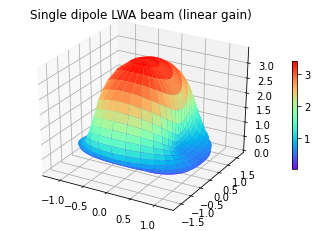

In [8]:
freq_idx = 52
beam_linear = 10**(beam/10)
thetarad = np.radians(thetamat)
phirad = np.radians(phimat)
X = beam_linear[:,:,freq_idx]*np.sin(thetarad)*np.cos(phirad)
Y = beam_linear[:,:,freq_idx]*np.sin(thetarad)*np.sin(phirad)
Z = beam_linear[:,:,freq_idx]*np.cos(thetarad)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Single dipole LWA beam (linear gain)')
surf = ax.plot_surface(X, Y, Z, cmap=mpl.cm.rainbow)
fig.colorbar(surf, shrink=0.5)
plt.show()